In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import importlib
import dataset
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import time
importlib.reload(dataset)

<module 'dataset' from 'c:\\Users\\Frederico\\Desktop\\DS\\Data-Science\\CIRI\\dataset.py'>

In [10]:
transform = transforms.Compose([
    # to-tensor
    transforms.ToTensor(),
    # resize
    transforms.Resize(128),
    # center-crop
    transforms.CenterCrop(128),
    # normalize
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

In [12]:
incidents = dataset.IncidentsDataset("Incidents-subset", transform=transform)

StopIteration: 

In [ ]:
train_indices, test_indices, _, _ = train_test_split(range(incidents.__len__()), incidents.targets, stratify=incidents.targets, test_size=.3)

In [ ]:
len(train_indices), len(test_indices), incidents.__len__()

(5541, 693, 693, 6927)

In [ ]:
train_split = Subset(incidents, train_indices)
test_split = Subset(incidents, test_indices)

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
test_loader = DataLoader(test_split, batch_size=32)


In [ ]:
dataloader = DataLoader(incidents, batch_size=32, shuffle=True)

In [ ]:
nSamples = incidents.__len__()
nClasses = len(incidents.labels)
imgShape = incidents.__getitem__(0)[0].shape

print("Number of samples: ", nSamples)
print("Number of classes: ", nClasses)
print("Shape of an image: ", imgShape)

Number of samples:  6927
Number of classes:  12
Shape of an image:  torch.Size([3, 128, 128])


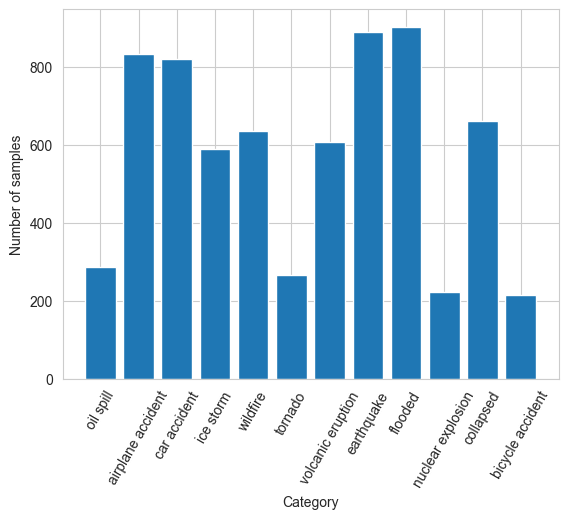

In [ ]:
target, counts = np.unique(incidents.targets, return_counts=True)

_, ax = plt.subplots()

ax.bar(incidents.labels[target], counts) #, width=1, edgecolor="white", linewidth=.7)
plt.ylabel("Number of samples")
plt.xlabel("Category")
plt.xticks(rotation=60)
plt.show()

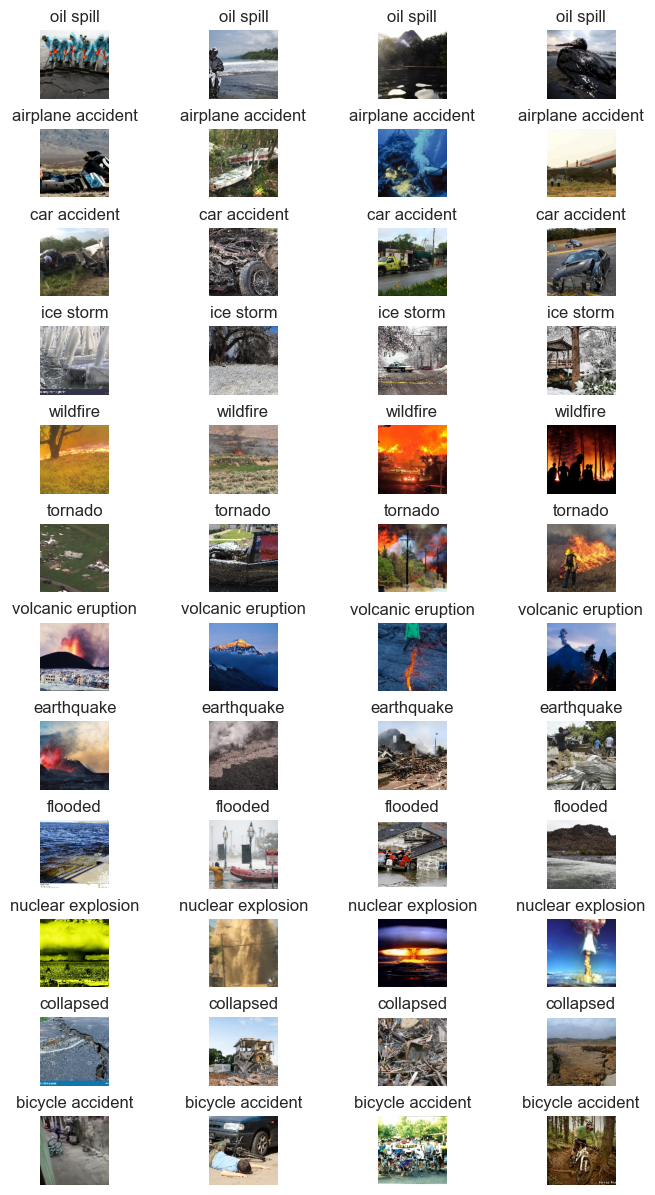

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(nClasses, 4), axes_pad=(1, .3))

images = []

for n in np.arange(nClasses):
    for i in range(4):
        img = incidents.get_item_with_target(n, i)
        idx = n*4+i
        grid[idx].imshow(img.permute(1, 2, 0))
        grid[idx].set_title(incidents.labels[n])
        grid[idx].axis('off')

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None, pretrained=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 15

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
start=time.time()
epochs = 5

for epoch in range(0,epochs):

  model.train()  # Put the network in train mode
  for i, (x_batch, y_batch) in enumerate(dataloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used
    
    # Compute prediction and loss
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)

    # Backpropagation
    optimizer.zero_grad()  # Set all currenly stored gradients to zero 
    loss.backward()
    optimizer.step()

    # Compute relevant metrics
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability
    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels
    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 20 batches 
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')
    
    correct_total = 0

  model.eval()  # Put the network in eval mode
  for i, (x_batch, y_batch) in enumerate(dataloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = model(x_batch)
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

  print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Epoch 0/14
----------


KeyboardInterrupt: 

In [ ]:
# for param in model.parameters():
#     param.requires_grad= False

# model = nn.Sequential(*list(model.children())[:-2])
# output_size = 2048
# batch_size = dataloader.batch_size

# cnn_descriptors = np.zeros((incidents.__len__(), output_size))
# targets = np.zeros((incidents.__len__(), 1))

# with torch.no_grad():
#     model.eval()

#     for j, (inputs, labels) in enumerate(dataloader):
#         outputs = np.array(model(inputs))[:, :, 0, 0]
#         # cnn_descriptors[j:j+4, :] = outputs
#         cnn_descriptors[j*batch_size:j*batch_size+batch_size, :] = outputs
#         targets[j*batch_size:j*batch_size+batch_size, 0] = labels

In [ ]:
# targets

array([[6.],
       [4.],
       [3.],
       ...,
       [5.],
       [3.],
       [6.]])